In [2]:
library('tidyverse')
library('ISLR2')
library('MASS')
library('caret')
library('GGally')
library('pROC')
library('e1071')
library('neuralnet')
library('leaps')

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘MASS’


The following object is masked from ‘package:ISLR2’:

    Boston


The following object is masked from ‘package:dplyr’:

    select


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: pROC

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked fro

In [3]:
heart_o <- read.csv('heart_cleveland_upload.csv')
dim(heart_o)
head(heart_o)
sum(is.na(heart_o))

[1] 297  14

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
2,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
3,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
4,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
5,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
6,64,1,0,170,227,0,2,155,0,0.6,1,0,2,0


[1] 0

age: age in years
sex: sex (1 = male; 0 = female)
cp: chest pain type
-- Value 0: typical angina
-- Value 1: atypical angina
-- Value 2: non-anginal pain
-- Value 3: asymptomatic
trestbps: resting blood pressure (in mm Hg on admission to the hospital)
chol: serum cholestoral in mg/dl
fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
restecg: resting electrocardiographic results
-- Value 0: normal
-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach: maximum heart rate achieved
exang: exercise induced angina (1 = yes; 0 = no)
oldpeak = ST depression induced by exercise relative to rest
slope: the slope of the peak exercise ST segment
-- Value 0: upsloping
-- Value 1: flat
-- Value 2: downsloping
ca: number of major vessels (0-3) colored by flourosopy
thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
and the label
condition: 0 = no disease, 1 = disease

In [4]:
heart_o$sex <- as.factor(heart_o$sex)
#heart_o$cp <- as.factor(heart_o$cp)
heart_o$fbs <- as.factor(heart_o$fbs)
heart_o$restecg <- as.factor(heart_o$restecg)
heart_o$exang <- as.factor(heart_o$exang)
heart_o$slope <- as.factor(heart_o$slope)
heart_o$thal <- as.factor(heart_o$thal)
heart_o$ca <- as.factor(heart_o$ca)
heart_o$condition <- as.factor(heart_o$condition) #target variable
head(heart_o)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
,<int>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
1,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
2,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
3,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
4,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
5,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
6,64,1,0,170,227,0,2,155,0,0.6,1,0,2,0


In [5]:
heart <- heart_o
heart <- heart%>%
        mutate(restecg = ifelse(restecg==0,0,1), restecg=factor(restecg))%>% #only 4 records, combine
        mutate(cp = ifelse(cp < 2,0,1), cp = factor(cp))
heart <- subset(heart, chol < 500)
summary(heart)

      age       sex     cp         trestbps          chol       fbs     restecg
 Min.   :29.0   0: 95   0: 72   Min.   : 94.0   Min.   :126.0   0:253   0:147  
 1st Qu.:48.0   1:201   1:224   1st Qu.:120.0   1st Qu.:211.0   1: 43   1:149  
 Median :56.0                   Median :130.0   Median :242.5                  
 Mean   :54.5                   Mean   :131.8   Mean   :246.3                  
 3rd Qu.:61.0                   3rd Qu.:140.0   3rd Qu.:275.2                  
 Max.   :77.0                   Max.   :200.0   Max.   :417.0                  
    thalach      exang      oldpeak      slope   ca      thal    condition
 Min.   : 71.0   0:199   Min.   :0.000   0:139   0:173   0:164   0:159    
 1st Qu.:133.0   1: 97   1st Qu.:0.000   1:136   1: 65   1: 18   1:137    
 Median :152.5           Median :0.800   2: 21   2: 38   2:114            
 Mean   :149.6           Mean   :1.054           3: 20                    
 3rd Qu.:166.0           3rd Qu.:1.650                           

In [6]:
set.seed(999)
validation <- sample_frac(heart, 0.2) #leave for final validation
validation_index <- as.numeric(rownames(validation))
train <- heart[-validation_index,]

tr <- trainControl(method = "repeatedcv", number = 10, repeats = 3)

In [7]:
fit.lr <- glm(condition ~., data = train, family=binomial)
summary(fit.lr)


Call:
glm(formula = condition ~ ., family = binomial, data = train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.79545  -0.42651   0.04827   0.36087   2.65444  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.816e+01  1.009e+03  -0.018 0.985647    
age         -2.938e-02  2.834e-02  -1.037 0.299925    
sex1         1.246e+00  5.871e-01   2.123 0.033771 *  
cp1          1.516e+01  1.009e+03   0.015 0.988014    
trestbps     3.156e-02  1.444e-02   2.186 0.028814 *  
chol         3.894e-03  4.902e-03   0.794 0.426968    
fbs1        -1.167e+00  6.383e-01  -1.828 0.067527 .  
restecg1     6.396e-01  4.414e-01   1.449 0.147355    
thalach     -2.801e-02  1.326e-02  -2.112 0.034653 *  
exang1       1.320e+00  4.671e-01   2.826 0.004718 ** 
oldpeak      3.811e-01  2.625e-01   1.452 0.146616    
slope1       6.221e-01  5.443e-01   1.143 0.253104    
slope2       1.696e-01  1.014e+00   0.167 0.867234    
ca1          1.799e+00

In [14]:
fit_best <- regsubsets(condition ~ ., data = train, nvmax = 17) 
fit_best_sum<-summary(fit_best)
fit_best_sum

Subset selection object
Call: regsubsets.formula(condition ~ ., data = train, nvmax = 17)
17 Variables  (and intercept)
         Forced in Forced out
age          FALSE      FALSE
sex1         FALSE      FALSE
cp1          FALSE      FALSE
trestbps     FALSE      FALSE
chol         FALSE      FALSE
fbs1         FALSE      FALSE
restecg1     FALSE      FALSE
thalach      FALSE      FALSE
exang1       FALSE      FALSE
oldpeak      FALSE      FALSE
slope1       FALSE      FALSE
slope2       FALSE      FALSE
ca1          FALSE      FALSE
ca2          FALSE      FALSE
ca3          FALSE      FALSE
thal1        FALSE      FALSE
thal2        FALSE      FALSE
1 subsets of each size up to 17
Selection Algorithm: exhaustive
          age sex1 cp1 trestbps chol fbs1 restecg1 thalach exang1 oldpeak
1  ( 1 )  " " " "  " " " "      " "  " "  " "      " "     " "    " "    
2  ( 1 )  " " " "  " " " "      " "  " "  " "      "*"     " "    " "    
3  ( 1 )  " " " "  " " " "      " "  " "  " "      "*"

In [15]:
fit_fwd <-regsubsets(condition ~ ., data = train, nvmax = 17, method = "forward")
fit_fwd_sum <- summary(fit_fwd) 
fit_fwd_sum

Subset selection object
Call: regsubsets.formula(condition ~ ., data = train, nvmax = 17, method = "forward")
17 Variables  (and intercept)
         Forced in Forced out
age          FALSE      FALSE
sex1         FALSE      FALSE
cp1          FALSE      FALSE
trestbps     FALSE      FALSE
chol         FALSE      FALSE
fbs1         FALSE      FALSE
restecg1     FALSE      FALSE
thalach      FALSE      FALSE
exang1       FALSE      FALSE
oldpeak      FALSE      FALSE
slope1       FALSE      FALSE
slope2       FALSE      FALSE
ca1          FALSE      FALSE
ca2          FALSE      FALSE
ca3          FALSE      FALSE
thal1        FALSE      FALSE
thal2        FALSE      FALSE
1 subsets of each size up to 17
Selection Algorithm: forward
          age sex1 cp1 trestbps chol fbs1 restecg1 thalach exang1 oldpeak
1  ( 1 )  " " " "  " " " "      " "  " "  " "      " "     " "    " "    
2  ( 1 )  " " " "  " " " "      " "  " "  " "      "*"     " "    " "    
3  ( 1 )  " " " "  " " " "      " "  

In [16]:
fit_bwd <- regsubsets(condition ~ ., data = train, nvmax = 17, method = "backward") 
fit_bwd_sum <- summary(fit_bwd) 
fit_bwd_sum

Subset selection object
Call: regsubsets.formula(condition ~ ., data = train, nvmax = 17, method = "backward")
17 Variables  (and intercept)
         Forced in Forced out
age          FALSE      FALSE
sex1         FALSE      FALSE
cp1          FALSE      FALSE
trestbps     FALSE      FALSE
chol         FALSE      FALSE
fbs1         FALSE      FALSE
restecg1     FALSE      FALSE
thalach      FALSE      FALSE
exang1       FALSE      FALSE
oldpeak      FALSE      FALSE
slope1       FALSE      FALSE
slope2       FALSE      FALSE
ca1          FALSE      FALSE
ca2          FALSE      FALSE
ca3          FALSE      FALSE
thal1        FALSE      FALSE
thal2        FALSE      FALSE
1 subsets of each size up to 17
Selection Algorithm: backward
          age sex1 cp1 trestbps chol fbs1 restecg1 thalach exang1 oldpeak
1  ( 1 )  " " " "  " " " "      " "  " "  " "      " "     " "    " "    
2  ( 1 )  " " " "  " " " "      " "  " "  " "      " "     " "    "*"    
3  ( 1 )  " " " "  " " " "      " "

In [17]:
results= data.frame( 
    "Cp" = c(which.min(summary(fit_best)$cp),which.min(summary(fit_fwd)$cp),
                             which.min(summary(fit_bwd)$cp)),
    "bic"= c(which.min(summary(fit_best)$bic),which.min(summary(fit_fwd)$bic),
                             which.min(summary(fit_bwd)$bic)), 
    "adjr2" = c(which.max(summary(fit_best)$adjr2),which.max(summary(fit_fwd)$adjr2),
                             which.max(summary(fit_bwd)$adjr2))
)

x=c("Best Subset selection", "Forward Stepwise","Backward Stepwise")

row.names(results) = x

results

,Cp,bic,adjr2
,<int>,<int>,<int>
Best Subset selection,12,7,13
Forward Stepwise,13,7,13
Backward Stepwise,12,7,13


In [23]:
fit.lr_fit <- glm(condition ~ .-cp-age-chol-slope, data = train, family=binomial)
summary(fit.lr_fit)


Call:
glm(formula = condition ~ . - cp - age - chol - slope, family = binomial, 
    data = train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.71464  -0.43177   0.04957   0.36028   2.60522  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.89225    2.34425  -1.234 0.217290    
sex1         1.06938    0.54182   1.974 0.048417 *  
trestbps     0.02784    0.01343   2.073 0.038174 *  
fbs1        -1.08351    0.62205  -1.742 0.081537 .  
restecg1     0.74151    0.42751   1.734 0.082830 .  
thalach     -0.02857    0.01151  -2.483 0.013029 *  
exang1       1.47138    0.46055   3.195 0.001399 ** 
oldpeak      0.53176    0.23019   2.310 0.020883 *  
ca1          1.72450    0.52145   3.307 0.000943 ***
ca2          3.22623    0.86825   3.716 0.000203 ***
ca3          2.00196    0.91264   2.194 0.028266 *  
thal1        0.34509    0.86554   0.399 0.690110    
thal2        1.61580    0.48018   3.365 0.000765 ***
---
Signif. codes: 

In [24]:
pred_lr_fit <-predict(fit.lr_fit, newdata = validation, type="response")
predict_labels_fit = ifelse(pred_lr_fit > 0.5, "1", "0") 
predict_labels_fit=as.factor(predict_labels_fit)
head(predict_labels_fit)
confusionMatrix(predict_labels_fit, validation$condition, positive="1")

1 2 3 4 5 6 
0 0 0 1 1 0 
Levels: 0 1

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 34  1
         1  3 21
                                          
               Accuracy : 0.9322          
                 95% CI : (0.8354, 0.9812)
    No Information Rate : 0.6271          
    P-Value [Acc > NIR] : 7.116e-08       
                                          
                  Kappa : 0.8577          
                                          
 Mcnemar's Test P-Value : 0.6171          
                                          
            Sensitivity : 0.9545          
            Specificity : 0.9189          
         Pos Pred Value : 0.8750          
         Neg Pred Value : 0.9714          
             Prevalence : 0.3729          
         Detection Rate : 0.3559          
   Detection Prevalence : 0.4068          
      Balanced Accuracy : 0.9367          
                                          
       'Positive' Class : 1               
                                    

Setting levels: control = 0, case = 1

Setting direction: controls < cases



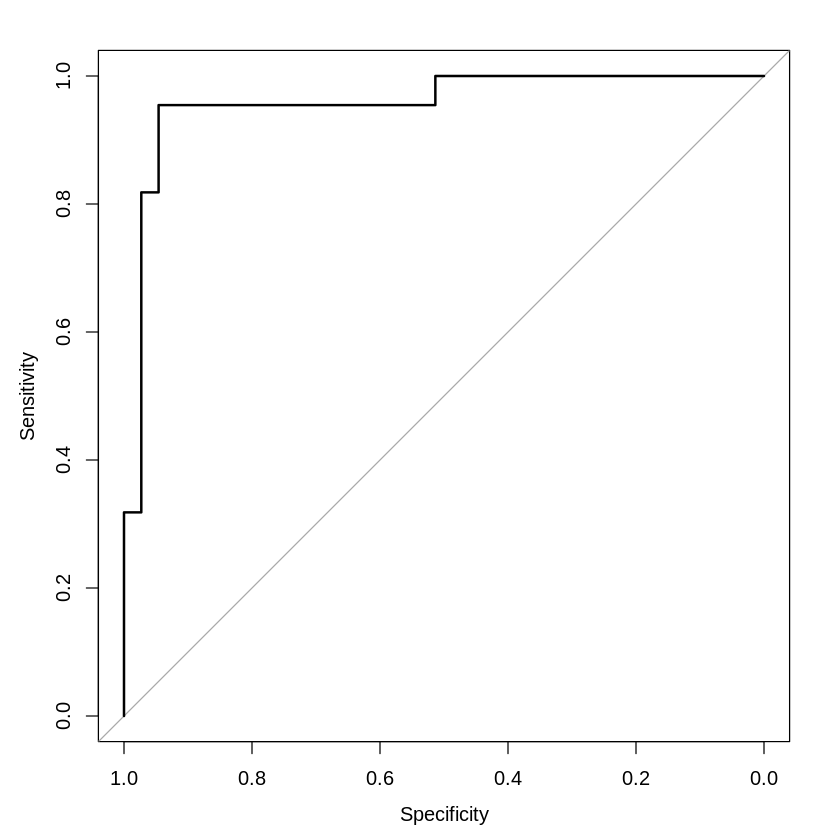

In [25]:
ROC_lr_fit <- roc(validation$condition, pred_lr_fit)
plot(ROC_lr_fit)

In [26]:
nb_model <- naiveBayes(condition ~ ., data = train, trControl = tr)
nb_pred <- predict(nb_model, validation)
#mse
mean((as.numeric(validation$condition) - as.numeric(nb_pred))^2)
#confusion matrix
confusionMatrix(nb_pred, validation$condition)

[1] 0.1016949

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 32  1
         1  5 21
                                          
               Accuracy : 0.8983          
                 95% CI : (0.7917, 0.9618)
    No Information Rate : 0.6271          
    P-Value [Acc > NIR] : 2.684e-06       
                                          
                  Kappa : 0.7903          
                                          
 Mcnemar's Test P-Value : 0.2207          
                                          
            Sensitivity : 0.8649          
            Specificity : 0.9545          
         Pos Pred Value : 0.9697          
         Neg Pred Value : 0.8077          
             Prevalence : 0.6271          
         Detection Rate : 0.5424          
   Detection Prevalence : 0.5593          
      Balanced Accuracy : 0.9097          
                                          
       'Positive' Class : 0               
                                    

Setting levels: control = 0, case = 1

Setting direction: controls < cases



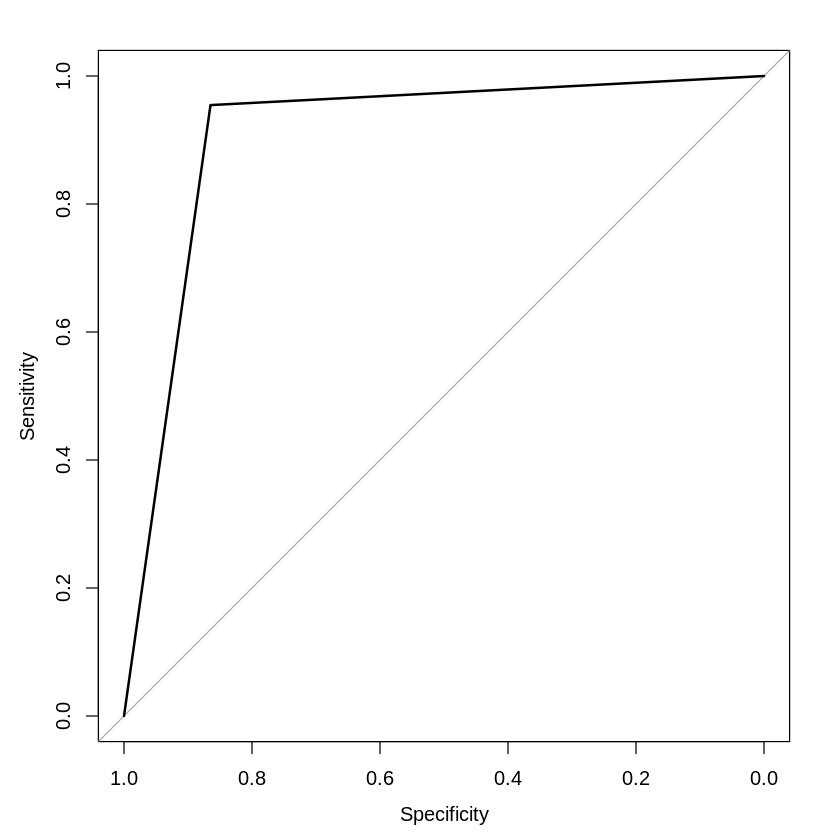

In [23]:
ROC_nb <- roc(validation$condition, as.numeric(nb_pred))
plot(ROC_nb)

In [17]:
#neural net

#scaling
scale.fun <- function(x){
  (x - min(x)) / (max(x) - min(x))
}

train_2 <- train %>% mutate_if(is.integer, scale.fun) 
vali_2<- validation %>% mutate_if(is.integer, scale.fun)

table(train_2$condition)
table(vali_2$condition)
summary(vali_2)
summary(train_2)


  0   1 
116 121 


 0  1 
37 22 

      age         sex    cp        trestbps           chol        fbs   
 Min.   :0.0000   0:20   0:19   Min.   :0.0000   Min.   :0.0000   0:52  
 1st Qu.:0.2619   1:39   1:40   1st Qu.:0.3023   1st Qu.:0.2462   1: 7  
 Median :0.5000                 Median :0.4186   Median :0.4162         
 Mean   :0.4722                 Mean   :0.4484   Mean   :0.4193         
 3rd Qu.:0.6310                 3rd Qu.:0.5349   3rd Qu.:0.5838         
 Max.   :1.0000                 Max.   :1.0000   Max.   :1.0000         
 restecg    thalach       exang     oldpeak      slope  ca     thal   condition
 0:33    Min.   :0.0000   0:39   Min.   :0.000   0:25   0:41   0:33   0:37     
 1:26    1st Qu.:0.4904   1:20   1st Qu.:0.000   1:28   1: 9   1: 4   1:22     
         Median :0.6442          Median :0.600   2: 6   2: 6   2:22            
         Mean   :0.6071          Mean   :1.122          3: 3                   
         3rd Qu.:0.7788          3rd Qu.:1.600                                 
         

      age         sex     cp         trestbps           chol        fbs    
 Min.   :0.0000   0: 77   0: 13   Min.   :0.0000   Min.   :0.0000   0:204  
 1st Qu.:0.3750   1:160   1:224   1st Qu.:0.2453   1st Qu.:0.2921   1: 33  
 Median :0.5417                   Median :0.3396   Median :0.4021          
 Mean   :0.5258                   Mean   :0.3491   Mean   :0.4128          
 3rd Qu.:0.6667                   3rd Qu.:0.4340   3rd Qu.:0.5120          
 Max.   :1.0000                   Max.   :1.0000   Max.   :1.0000          
 restecg    thalach       exang      oldpeak      slope   ca      thal   
 0:118   Min.   :0.0000   0:148   Min.   :0.000   0:106   0:132   0:123  
 1:119   1st Qu.:0.4656   1: 89   1st Qu.:0.000   1:115   1: 55   1: 15  
         Median :0.6031           Median :0.800   2: 16   2: 31   2: 99  
         Mean   :0.5833           Mean   :1.125           3: 19          
         3rd Qu.:0.7023           3rd Qu.:1.800                          
         Max.   :1.0000 

In [18]:
#one-hot
train_dummy <- model.matrix(~ sex + cp + fbs + restecg + slope + ca + thal + condition, train_2)[,-1]
head(train_dummy)
train_cbind <- cbind(train_2, train_dummy)
set.seed(5)
str(train_cbind)
train_cbind <- train_cbind[,c(-2,-3,-6,-7,-9,-11:-15)]
str(train_cbind)

fit.nn <- neuralnet(condition1 ~., data = train_cbind,
                 linear.output = FALSE, err.fct = "ce")

fit.nn$result.matrix

,sex1,cp1,fbs1,restecg1,slope1,slope2,ca1,ca2,ca3,thal1,thal2,condition1
60,1,0,0,0,0,0,0,0,0,0,1,0
61,1,0,0,1,0,0,0,0,0,0,0,0
62,1,0,0,0,0,0,0,0,0,0,0,0
63,1,0,0,0,0,0,0,0,0,0,0,0
64,1,0,0,0,1,0,0,0,0,1,0,0
65,0,0,0,1,0,0,0,0,0,0,0,0


'data.frame':	237 obs. of  26 variables:
 $ age       : num  0.312 0.312 0.312 0.271 0.25 ...
 $ sex       : Factor w/ 2 levels "0","1": 2 2 2 2 2 1 1 2 1 2 ...
 $ cp        : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ trestbps  : num  0.245 0.34 0.245 0.245 0.387 ...
 $ chol      : num  0.471 0.32 0.323 0.581 0.265 ...
 $ fbs       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ restecg   : Factor w/ 2 levels "0","1": 1 2 1 1 1 2 1 1 1 1 ...
 $ thalach   : num  0.779 0.893 0.756 0.695 0.466 ...
 $ exang     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ oldpeak   : num  0 0 0 0 0 1.4 0 0 0 0 ...
 $ slope     : Factor w/ 3 levels "0","1","2": 1 1 1 1 2 1 1 1 1 1 ...
 $ ca        : Factor w/ 4 levels "0","1","2","3": 1 1 1 1 1 1 2 1 1 1 ...
 $ thal      : Factor w/ 3 levels "0","1","2": 3 1 1 1 2 1 1 1 1 1 ...
 $ condition : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ sex1      : num  1 1 1 1 1 0 0 1 0 1 ...
 $ cp1       : num  0 0 0 0 0 0 0 0 0

error,6.936633e+01
reached.threshold,9.884887e-03
steps,7.870000e+03
Intercept.to.1layhid1,1.458193e+00
age.to.1layhid1,6.167111e+01
trestbps.to.1layhid1,-4.590607e+01
chol.to.1layhid1,1.362008e+01
thalach.to.1layhid1,7.970114e+01
oldpeak.to.1layhid1,-2.232416e+00
cp1.to.1layhid1,-2.896019e+01
fbs1.to.1layhid1,1.125713e+01


In [27]:
set.seed(5)
# 2-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron
fit.nn.21 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(2,1))

In [28]:
# 2-Hidden Layers: Layer-1 3-neurons, Layer-2, 1-neuron
fit.nn.31 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(3,1))

In [35]:
# 2-Hidden Layers: Layer-1 3-neurons, Layer-2, 2-neuron
fit.nn.32 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(3,2))

In [36]:
# 2-Hidden Layers: Layer-1 4-neurons, Layer-2, 1-neuron
fit.nn.41 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(4,1))

In [38]:
# 2-Hidden Layers: Layer-1 5-neurons, Layer-2, 1-neuron
fit.nn.51 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(5,1))

In [39]:
# 2-Hidden Layers: Layer-1 6-neurons, Layer-2, 1-neuron
fit.nn.61 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(6,1))

In [41]:
# 2-Hidden Layers: Layer-1 5-neurons, Layer-2, 2-neuron
fit.nn.52 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(5,2))

In [44]:
# 2-Hidden Layers: Layer-1 5-neurons, Layer-2, 3-neuron
fit.nn.53 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(5,3))

In [29]:
# 2-Hidden Layers: Layer-1 1-neurons, Layer-2, 3-neuron
fit.nn.13 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(1,3))

Warning message:
“Algorithm did not converge in 1 of 1 repetition(s) within the stepmax.”


In [30]:
# 3-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 1-neuron
fit.nn.211 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(2,1,1))

In [31]:
# 3-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 2-neuron
fit.nn.212 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(2,1,2))

In [32]:
# 4-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 1-neuron, Layer-4, 1-neuron
fit.nn.2111 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(2,1,1,1))

In [33]:
# 2-Hidden Layers, Layer-1 2-neurons, Layer-2, 2-neurons
fit.nn.22 <- neuralnet(condition1 ~., 
                                data = train_cbind, 
                                linear.output = FALSE, 
                                err.fct = 'ce', 
                                hidden = c(2,2))

In [42]:
# 2-Hidden Layers, Layer-1 1-neuron, Layer-2, 2-neuron
fit.nn.12 <- neuralnet(condition1 ~ ., 
                                data = train_cbind, 
                                linear.output = FALSE, 
                                err.fct = 'ce',
                                hidden = c(1,2))

[1] "Error with 2-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron is: 55.7314950087805"

[1] "Error with 2-Hidden Layers: Layer-1 3-neurons, Layer-2, 1-neuron is: 36.8852752172569"

[1] "Error with 2-Hidden Layers: Layer-1 3-neurons, Layer-2, 2-neurons is: 26.672052928042"

[1] "Error with 2-Hidden Layers: Layer-1 4-neurons, Layer-2, 1-neuron is: 20.8956645250366"

[1] "Error with 2-Hidden Layers: Layer-1 5-neurons, Layer-2, 1-neuron is: 15.9920068974659"

[1] "Error with 2-Hidden Layers: Layer-1 6-neurons, Layer-2, 1-neuron is: 44.1199185696359"

[1] "Error with 2-Hidden Layers: Layer-1 5-neurons, Layer-2, 2-neurons is: 0.0158585180378007"

[1] "Error with 2-Hidden Layers: Layer-1 1-neuron, Layer-2, 3-neurons is: "

[1] "Error with 3-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 1-neuron is: 51.9630446980057"

[1] "Error with 3-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 2-neurons is: 67.3967204048539"

[1] "Error with 4-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 1-neuron, Layer-4, 1-neuron is: 70.3955253852198"

[1] "Error with 2-Hidden Layers, Layer-1 2-neurons, Layer-2, 2-neurons is: 48.2799366235978"

[1] "Error with 2-Hidden Layers, Layer-1 1-neuron, Layer-2, 2-neurons is: 63.1301319251313"

In [45]:
paste("Error with 2-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron is:",  fit.nn.21$result.matrix[1,1])
paste("Error with 2-Hidden Layers: Layer-1 3-neurons, Layer-2, 1-neuron is:",  fit.nn.31$result.matrix[1,1])
paste("Error with 2-Hidden Layers: Layer-1 3-neurons, Layer-2, 2-neurons is:",  fit.nn.32$result.matrix[1,1])
paste("Error with 2-Hidden Layers: Layer-1 4-neurons, Layer-2, 1-neuron is:",  fit.nn.41$result.matrix[1,1])
paste("Error with 2-Hidden Layers: Layer-1 5-neurons, Layer-2, 1-neuron is:",  fit.nn.51$result.matrix[1,1])
paste("Error with 2-Hidden Layers: Layer-1 6-neurons, Layer-2, 1-neuron is:",  fit.nn.61$result.matrix[1,1])
paste("Error with 2-Hidden Layers: Layer-1 5-neurons, Layer-2, 2-neurons is:",  fit.nn.52$result.matrix[1,1])
paste("Error with 2-Hidden Layers: Layer-1 5-neurons, Layer-2, 3-neurons is:",  fit.nn.53$result.matrix[1,1])
paste("Error with 2-Hidden Layers: Layer-1 1-neuron, Layer-2, 3-neurons is:",  fit.nn.13$result.matrix[1,1])
paste("Error with 3-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 1-neuron is:",  fit.nn.211$result.matrix[1,1])
paste("Error with 3-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 2-neurons is:",  fit.nn.212$result.matrix[1,1])
paste("Error with 4-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 1-neuron, Layer-4, 1-neuron is:",  fit.nn.2111$result.matrix[1,1])
paste("Error with 2-Hidden Layers, Layer-1 2-neurons, Layer-2, 2-neurons is:", fit.nn.22$result.matrix[1,1])
paste("Error with 2-Hidden Layers, Layer-1 1-neuron, Layer-2, 2-neurons is:", fit.nn.12$result.matrix[1,1])

[1] "Error with 2-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron is: 55.7314950087805"

[1] "Error with 2-Hidden Layers: Layer-1 3-neurons, Layer-2, 1-neuron is: 36.8852752172569"

[1] "Error with 2-Hidden Layers: Layer-1 3-neurons, Layer-2, 2-neurons is: 26.672052928042"

[1] "Error with 2-Hidden Layers: Layer-1 4-neurons, Layer-2, 1-neuron is: 20.8956645250366"

[1] "Error with 2-Hidden Layers: Layer-1 5-neurons, Layer-2, 1-neuron is: 15.9920068974659"

[1] "Error with 2-Hidden Layers: Layer-1 6-neurons, Layer-2, 1-neuron is: 44.1199185696359"

[1] "Error with 2-Hidden Layers: Layer-1 5-neurons, Layer-2, 2-neurons is: 0.0158585180378007"

[1] "Error with 2-Hidden Layers: Layer-1 5-neurons, Layer-2, 3-neurons is: 23.9668760956435"

[1] "Error with 2-Hidden Layers: Layer-1 1-neuron, Layer-2, 3-neurons is: "

[1] "Error with 3-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 1-neuron is: 51.9630446980057"

[1] "Error with 3-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 2-neurons is: 67.3967204048539"

[1] "Error with 4-Hidden Layers: Layer-1 2-neurons, Layer-2, 1-neuron, Layer-3, 1-neuron, Layer-4, 1-neuron is: 70.3955253852198"

[1] "Error with 2-Hidden Layers, Layer-1 2-neurons, Layer-2, 2-neurons is: 48.2799366235978"

[1] "Error with 2-Hidden Layers, Layer-1 1-neuron, Layer-2, 2-neurons is: 63.1301319251313"

In [47]:
vali_dummy <- model.matrix(~ sex + cp + fbs + restecg + slope + ca + thal + condition, vali_2)[,-1]
head(vali_dummy)
vali_cbind <- cbind(vali_2, vali_dummy)
set.seed(5)
str(vali_cbind)
vali_cbind <- vali_cbind[,c(-2,-3,-6,-7,-9,-11:-15)]
str(vali_cbind)

,sex1,cp1,fbs1,restecg1,slope1,slope2,ca1,ca2,ca3,thal1,thal2,condition1
1,1,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,0,0
4,0,1,0,1,0,1,0,0,1,0,1,1
5,1,0,0,1,0,1,0,0,0,0,1,0
6,0,1,0,0,1,0,0,0,0,0,0,0


'data.frame':	59 obs. of  26 variables:
 $ age       : num  0.238 0 0.214 0.667 0.595 ...
 $ sex       : Factor w/ 2 levels "0","1": 2 1 1 1 2 1 2 2 2 2 ...
 $ cp        : Factor w/ 2 levels "0","1": 1 1 2 2 1 2 2 2 1 2 ...
 $ trestbps  : num  0.419 0.279 0.326 0.767 0.977 ...
 $ chol      : num  0.3147 0.269 0.2843 0.0355 0.5736 ...
 $ fbs       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ restecg   : Factor w/ 2 levels "0","1": 2 1 1 2 2 1 1 1 1 2 ...
 $ thalach   : num  0.962 1 0.74 0.548 0.548 ...
 $ exang     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 1 1 1 ...
 $ oldpeak   : num  0 0.7 0.2 6.2 4.2 0 2.8 0.5 0 0.4 ...
 $ slope     : Factor w/ 3 levels "0","1","2": 1 1 2 3 3 2 3 2 1 2 ...
 $ ca        : Factor w/ 4 levels "0","1","2","3": 1 1 1 4 1 1 1 1 1 1 ...
 $ thal      : Factor w/ 3 levels "0","1","2": 1 1 1 3 3 1 2 3 1 1 ...
 $ condition : Factor w/ 2 levels "0","1": 1 1 1 2 1 1 2 1 1 1 ...
 $ sex1      : num  1 0 0 0 1 0 1 1 1 1 ...
 $ cp1       : num  0 0 1 1 

In [106]:
set.seed(5)
fit.nn.52 <- neuralnet(condition1 ~.,
                     data = train_cbind, 
                     linear.output = FALSE, 
                     err.fct = 'ce', 
                     hidden = c(5,2), 
                     likelihood = TRUE)

predict.nn_52<- predict(fit.nn.52,vali_cbind)
#Converting probabilities into binary classes setting threshold level 0.5
predict.nn_52 <- ifelse(predict.nn_52>0.5, 1, 0)
acc_vali_52 <- mean(predict.nn_52==vali_cbind$condition1)
acc_vali_52

[1] 0.8983051

In [99]:
predict.nn_52 <- as.factor(predict.nn_52)
predict.nn_52
vali_cbind$condition1 <- as.factor(vali_cbind$condition1)
confusionMatrix(predict.nn_52, vali_cbind$condition1)

[1] 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0
[39] 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1
Levels: 0 1

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 33  2
         1  4 20
                                          
               Accuracy : 0.8983          
                 95% CI : (0.7917, 0.9618)
    No Information Rate : 0.6271          
    P-Value [Acc > NIR] : 2.684e-06       
                                          
                  Kappa : 0.7865          
                                          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.8919          
            Specificity : 0.9091          
         Pos Pred Value : 0.9429          
         Neg Pred Value : 0.8333          
             Prevalence : 0.6271          
         Detection Rate : 0.5593          
   Detection Prevalence : 0.5932          
      Balanced Accuracy : 0.9005          
                                          
       'Positive' Class : 0               
                                    

In [100]:
mean((as.numeric(vali_cbind$condition1) - as.numeric(predict.nn_52))^2)

[1] 0.1016949

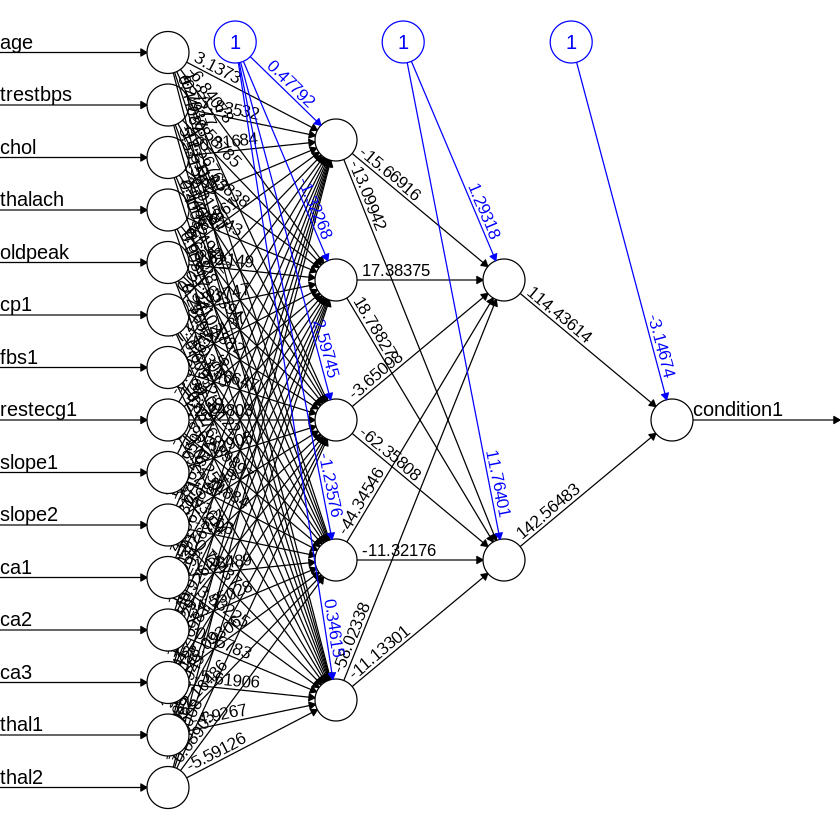

In [101]:
plot(fit.nn.52, 
     rep="best")

Setting levels: control = 1, case = 2

Setting direction: controls < cases



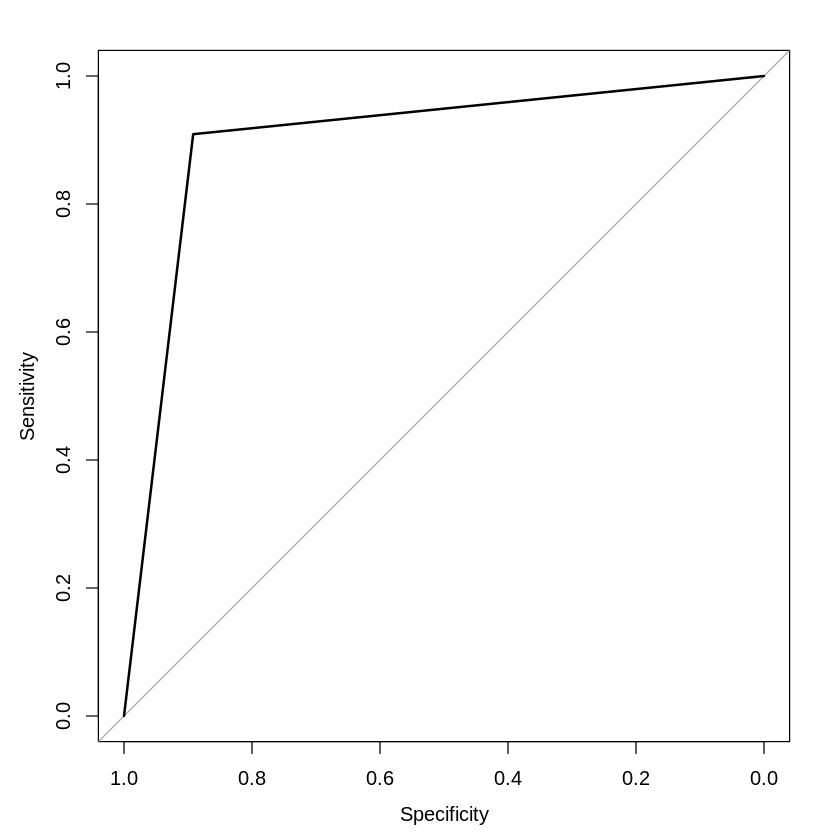

In [105]:
ROC_nn <- roc(as.numeric(vali_cbind$condition1), as.numeric(predict.nn_52))
plot(ROC_nn)